In [1]:
import operator
import random
import requests
import time
import csv
import os
import pandas as pd
import seaborn as sns
import numpy as np
import networkx as nx
from scipy import stats
from ast import literal_eval
from matplotlib import pyplot as plt
from statsmodels.stats import diagnostic
from datetime import datetime
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split

# Data standard scaler
from sklearn.preprocessing import StandardScaler

# Random train-test split
from sklearn.model_selection import train_test_split

# Metrics and model selection
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, auc, roc_curve, precision_recall_curve
from sklearn.model_selection import cross_val_predict

# Classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

from scipy.stats import ttest_ind

#To visualize on of the RandomForest decision trees
#from sklearn import tree

#colors used when comparing genders
PURPLE = 'purple'
ORANGE = '#ffb82c'

#colors used when generic comparisons
BLUE = '#0173b2'
RED = '#d55e00'

#print(sns.color_palette("colorblind").as_hex())
#sns.color_palette("colorblind")

In [2]:
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

# 1. Load the data
<a class="anchor" id="load"></a>

In [6]:
DATA_PATH = './data'
MOVIE_PATH = os.path.join(DATA_PATH, 'american_movies_filtered.tsv')
CHAR_PATH = os.path.join(DATA_PATH, 'characters_filtered.tsv')
THE_NUMBERS_PATH = os.path.join(DATA_PATH, 'the_numbers_lifetime_cumulative.tsv')
THE_NUMBERS_PATH_YEARLY = os.path.join(DATA_PATH, 'the_numbers_yearly_score.tsv')

### 1.1 Characters data
<a class="anchor" id="load_characters"></a>

In [4]:
df_chars=pd.read_csv(CHAR_PATH, sep="\t")
df_chars['m_release_date']=pd.to_datetime(df_chars['m_release_date'], errors = 'coerce')
df_chars.head(2)

,wikipedia_m_ID,m_release_date,character_name,actor_dob,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age,m_genre_PCA
0,975900,2001-08-24,Akooshay,1958-08-26,F,1.62,NaN,Wanda De Jesus,42.0,"Thriller, Crime Thriller, Action, Mystery"
1,975900,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.78,NaN,Natasha Henstridge,27.0,"Thriller, Crime Thriller, Action, Mystery"


### 1.2 Movies data
<a class="anchor" id="load_movies"></a>

In [5]:
df_movies=pd.read_csv(MOVIE_PATH, sep='\t')
df_movies['m_release_date']=pd.to_datetime(df_movies['m_release_date'], errors = 'coerce')
df_movies.head(2)

,wikipedia_m_ID,m_name,m_release_date,m_BO_revenue,m_runtime,m_languages,m_countries,m_genres,m_genre_PCA,character_name,actor_dob,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age
0,975900,Ghosts of Mars,2001-08-24,14010832.0,98.0,['English Language'],United States of America,"['Thriller', 'Science Fiction', 'Horror', 'Adv...","Thriller, Crime Thriller, Action, Mystery",Akooshay,1958-08-26,F,1.62,NaN,Wanda De Jesus,42.0
1,3196793,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,['English Language'],United States of America,"['Mystery', 'Biographical film', 'Drama', 'Cri...","Mystery, Horror, Children's/Family, Drama",Reporter,1956-12-19,F,NaN,NaN,Alice Barrett,43.0


### 1.4 The numbers data yearly

In [15]:
df_numbers=pd.read_csv(THE_NUMBERS_PATH_YEARLY, sep='\t').set_index('actor_name')
df_numbers.reset_index(inplace=True)
df_numbers.head(2)

,actor_name,1980,1981,1982,1983,1984,1985,1986,1987,1988,...,2005,2006,2007,2008,2009,2010,2011,2012,min_year,min_year_score
0,Jane Fonda,2475.0,3910.5,2161.5,1509.75,1163.25,947.100000,2689.071429,1636.232143,1239.125000,...,3026.612308,1649.474359,1183.301948,945.483026,799.422414,699.538710,626.261864,569.781250,1980,2475.0
1,Clint Eastwood,5394.0,2697.0,4636.0,5963.50,9801.80,8879.333333,8991.838095,5988.366667,7511.228571,...,5771.129002,4778.685758,4185.983006,8665.604883,5901.331475,4831.223973,4212.135890,4683.724922,1980,5394.0


# 2.1 Df chars cleaning

In [10]:
df_chars[df_chars['m_release_date'].dt.year < 1980]['actor_name'].unique()

array(['Ruth Chatterton', 'Fredric March', 'Florence Rice', ...,
       'Fred Groves', 'Duke R. Lee', 'Rich Little'], dtype=object)

In [11]:
df_chars['wikipedia_m_ID'].nunique()

24884

In [106]:
df_tmp = df_chars.copy()
df_tmp['m_release_year'] = df_tmp['m_release_date'].dt.year
df_tmp = df_tmp.groupby('actor_name').agg({'m_release_year': ['min', 'max']})
df_tmp = df_tmp['m_release_year']
df_tmp = df_tmp.loc[(df_tmp['min']<1980) & (df_tmp['max']>1980)]
df_tmp.reset_index(inplace=True)
df_tmp.head()

,actor_name,min,max
0,A. Michael Baldwin,1976,1998
1,Abbe Lane,1955,1983
2,Abby Dalton,1957,1994
3,Abe Vigoda,1972,2003
4,Abel Ferrara,1979,2009


In [107]:
df_e = pd.merge(df_tmp, df_chars_merged, on='actor_name', how='left').copy()
df_e.head()

,actor_name,min,max,wikipedia_m_ID,m_release_date,character_name,actor_dob,actor_gender,actor_height,actor_ethnicity,...,F_nb_famous_actors,F_prop_famous_actors,M_max,M_min,M_mean,M_median,M_nb_famous_actors,M_prop_famous_actors,is_revealed,already_revealed
0,A. Michael Baldwin,1976,1998,3305261,1994-01-01,NaN,1963-04-04,M,NaN,NaN,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0,0
1,A. Michael Baldwin,1976,1998,3305282,1998-01-01,NaN,1963-04-04,M,NaN,NaN,...,NaN,NaN,0.0,0.0,0.000000,0.0,0.0,0.0,0,0
2,Abbe Lane,1955,1983,1318335,1983-06-24,NaN,1932-12-14,F,1.650,Jewish people,...,0.0,0.0,244.0,0.0,18.769231,0.0,1.0,1.0,0,0
3,Abby Dalton,1957,1994,22914827,1994-01-01,NaN,1935-08-15,F,NaN,NaN,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0,0
4,Abe Vigoda,1972,2003,17547483,1997-05-09,NaN,1921-02-24,M,1.842,Russian Americans,...,1.0,1.0,0.0,0.0,0.000000,0.0,0.0,0.0,0,0


In [112]:
df_e.loc[(df_e['min_year_score'] > 0) & (df_e['min_year']>1980)].sort_values(['actor_name', 'is_revealed']).drop_duplicates(['actor_name'], keep='last')

,actor_name,min,max,wikipedia_m_ID,m_release_date,character_name,actor_dob,actor_gender,actor_height,actor_ethnicity,...,F_nb_famous_actors,F_prop_famous_actors,M_max,M_min,M_mean,M_median,M_nb_famous_actors,M_prop_famous_actors,is_revealed,already_revealed
66,Adrian Zmed,1978,2005,1841530,1984-06-29,Jay O'Neill,1954-03-04,M,1.727,NaN,...,1.0,1.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,1,0
181,Alan Alda,1968,2011,4824326,1990-06-22,Eddie Hopper,1936-01-28,M,1.880,Irish Americans,...,3.0,1.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,1,0
217,Alan Arkin,1966,2012,2000074,1992-09-01,George Aaronow,1934-03-26,M,1.750,Jewish people,...,NaN,NaN,3059.722222,0.0,410.055556,0.000000,4.0,1.0,1,0
331,Albert Brooks,1976,2012,2304640,1991-01-01,Daniel Miller,1947-07-22,M,1.780,Jewish people,...,2.0,1.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,1,0
473,Alfre Woodard,1978,2012,4511738,1993-06-24,NaN,1952-11-08,F,1.600,African Americans,...,2.0,0.5,2047.687179,0.0,822.363462,620.883333,2.0,0.5,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26111,William Hickey,1968,1997,591310,1990-01-01,NaN,1927-09-19,M,NaN,NaN,...,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,1,0
26189,William Katt,1976,2010,4370892,1986-02-28,NaN,1951-02-16,M,1.740,NaN,...,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,1,0
26296,William Shatner,1958,2012,27098,1982-06-04,James T. Kirk,1931-03-22,M,1.770,Polish Canadians,...,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,1,0
26336,Willie Nelson,1979,2011,694787,2005-08-05,Jesse Duke,1933-04-30,M,1.676,NaN,...,0.0,0.0,821.000000,0.0,120.230769,0.000000,3.0,1.0,1,0


In [123]:
df_e.loc[(df_e['min_year_score'] > 0) & (df_e['min_year']>1980)].sort_values(['actor_name', 'is_revealed']).drop_duplicates(['actor_name'], keep='last').to_csv('actors_with_pb.tsv', sep="\t", index=False)

In [89]:
df_chars_merged.loc[df_chars_merged['actor_name'] == 'Katharine Hepburn']['min_year']

2621      1981.0
33443     1981.0
65701     1981.0
136075    1981.0
139138    1981.0
159042    1981.0
163616    1981.0
Name: min_year, dtype: float64

In [93]:
df_e.loc[(df_e['min_year_score'] > 0)]['actor_name'].nunique()

1065

# 2.3 Compute number of actors per movie

In [19]:
#compute number of actors per movie
nb_actors_per_movie = df_chars['wikipedia_m_ID'].value_counts().reset_index().copy()
nb_actors_per_movie.rename({'wikipedia_m_ID': 'nb_actors', 'index': 'wikipedia_m_ID'}, axis=1, inplace=True)

In [20]:
#add nb of actors per movie
df_movies = df_movies.merge(nb_actors_per_movie, on='wikipedia_m_ID', how='left').copy()
df_chars = df_chars.merge(nb_actors_per_movie, on='wikipedia_m_ID', how='left').copy()

In [21]:
nb_unique_movies_in_movies = df_movies['wikipedia_m_ID'].nunique()
nb_unique_movies_in_chars = df_chars['wikipedia_m_ID'].nunique()
print("Number of unique movies in movies={} and in chars={} --> {}".format(nb_unique_movies_in_movies, nb_unique_movies_in_chars, nb_unique_movies_in_movies==nb_unique_movies_in_chars))

Number of unique movies in movies=24884 and in chars=24884 --> True


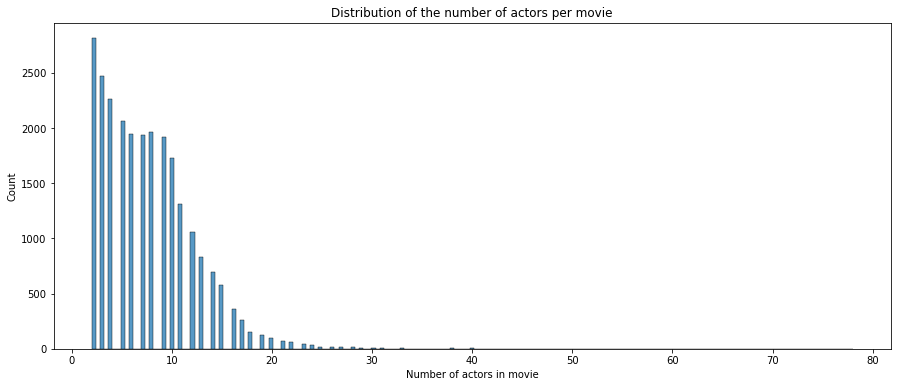

In average, there is 7.61 actors per movie among the american movies dataset with more than two actors.
There are 24884 unique movies which have a known list of actors greater than 2.


In [22]:
#nb actors per movie
plt.figure(figsize=(15, 6))
sns.histplot(data=df_movies, x='nb_actors')
plt.title("Distribution of the number of actors per movie")
plt.ylabel("Count")
plt.xlabel("Number of actors in movie")
plt.show()
avg_nb_actors_per_movie = df_movies['nb_actors'].mean()
nb_unique_movies_with_actors = df_movies['wikipedia_m_ID'].nunique()
print("In average, there is {:.2f} actors per movie among the american movies dataset with more than two actors.".format(avg_nb_actors_per_movie))
print("There are {} unique movies which have a known list of actors greater than 2.".format(nb_unique_movies_with_actors))

# 3.4 Number of movies of actor when releasing movie

In [25]:
#merge: if known score, column of score is = to score, otherwise = 0
df_chars_numbers = df_chars.merge(df_numbers, on='actor_name', how='left').copy()
df_chars_numbers.head()

,wikipedia_m_ID,m_release_date,character_name,actor_dob,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age,m_genre_PCA,...,2005,2006,2007,2008,2009,2010,2011,2012,min_year,min_year_score
0,975900,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,"Thriller, Crime Thriller, Action, Mystery",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,975900,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,NaN,Natasha Henstridge,27.0,"Thriller, Crime Thriller, Action, Mystery",...,76.000000,65.142857,57.000000,50.666667,45.600000,41.454545,38.000000,35.076923,2000.0,456.0
2,975900,2001-08-24,Desolation Williams,1969-06-15,M,1.727,African Americans,Ice Cube,32.0,"Thriller, Crime Thriller, Action, Mystery",...,3255.369913,1990.897222,2641.254319,2432.196392,1729.285333,1391.918606,1179.534513,1029.515124,1991.0,78.0
3,975900,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,"Thriller, Crime Thriller, Action, Mystery",...,715.333333,426.228571,311.050000,930.650794,546.942857,2009.549784,1152.650000,2576.304895,2000.0,38.0
4,975900,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea Duvall,23.0,"Thriller, Crime Thriller, Action, Mystery",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [27]:
df_numbers[df_numbers['actor_name']=='Alan Alda']

,actor_name,1980,1981,1982,1983,1984,1985,1986,1987,1988,...,2005,2006,2007,2008,2009,2010,2011,2012,min_year,min_year_score
6,Alan Alda,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,24.375,22.941176,21.666667,20.526316,19.5,18.571429,17.727273,16.956522,1990,390.0


# 3.5 Number of movies per decade

In [31]:
nb_decades_lower = range(1980, 2030, 10)
nb_decades_upper = range(1990, 2030, 10)
list_decades = dict()
for dec_lower, dec_upper in zip(nb_decades_lower, nb_decades_upper):
    filter_conditions = (
        (map_nb_movies_per_year['m_release_year'] >= dec_lower)&
        (map_nb_movies_per_year['m_release_year'] < dec_upper)
    )
    list_dec = map_nb_movies_per_year.loc[filter_conditions]
    list_dec = list_dec.groupby('actor_name')['wikipedia_m_ID'].count().reset_index()
    list_dec['wikipedia_m_ID'] =list_dec['wikipedia_m_ID'].astype(int)
    list_dec.rename({'wikipedia_m_ID': 'nb_movies_dec_{}_{}'.format(dec_lower, dec_upper)}, axis=1, inplace=True)
    list_decades.update({range(dec_lower, dec_upper): list_dec})

In [32]:
for key, dec in list_decades.items():
    df_chars_numbers = df_chars_numbers.merge(dec, on='actor_name', how='left')
    df_chars_numbers['nb_movies_dec_{}_{}'.format(key.start, key.stop)].fillna(0, inplace=True)

In [33]:
df_chars_numbers.head(2)

,wikipedia_m_ID,m_release_date,character_name,actor_dob,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age,m_genre_PCA,...,2009,2010,2011,2012,min_year,min_year_score,nb_movies_dec_1980_1990,nb_movies_dec_1990_2000,nb_movies_dec_2000_2010,nb_movies_dec_2010_2020
0,975900,2001-08-24,Akooshay,1958-08-26,F,1.62,NaN,Wanda De Jesus,42.0,"Thriller, Crime Thriller, Action, Mystery",...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,2.0,4.0,0.0
1,975900,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.78,NaN,Natasha Henstridge,27.0,"Thriller, Crime Thriller, Action, Mystery",...,45.6,41.454545,38.0,35.076923,2000.0,456.0,0.0,3.0,6.0,0.0


# 3.5 Compute scores per actor at movie time

In [34]:
df_chars_numbers = df_chars_numbers[df_chars_numbers['m_release_date'].dt.year > 1980].copy()

In [35]:
nb_unique_movies = df_chars_numbers['wikipedia_m_ID'].nunique()
print("There are {} unique movies with coacting.".format(nb_unique_movies))

There are 13712 unique movies with coacting.


In [38]:
def get_movie_actor_score(row):
    release_date = row['m_release_date'].year
    val = row[str(release_date-1)]
    if val > 0:
        return val
    else:
        return 0

In [39]:
df_chars_numbers['actor_score'] = df_chars_numbers.apply(lambda row: get_movie_actor_score(row), axis=1)

In [40]:
sns.scatterplot(data = df_chars_numbers[df_chars_numbers['actor_score']>0], y='nb_years_acting', x='actor_score');

ValueError: Could not interpret value `nb_years_acting` for parameter `y`

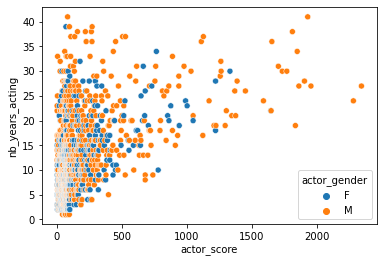

In [119]:
sns.scatterplot(data = df_chars_numbers.loc[(df_chars_numbers['actor_score']>0)].sort_values('actor_score').drop_duplicates('actor_name', keep='last'), y='nb_years_acting', x='actor_score', hue="actor_gender");

In [120]:
women_nb_movies_highest_score = df_chars_numbers.loc[(df_chars_numbers['actor_score']>0) & (df_chars_numbers['actor_gender']=='F')].sort_values('actor_score').drop_duplicates('actor_name', keep='last')['nb_years_acting']
men_nb_movies_highest_score = df_chars_numbers.loc[(df_chars_numbers['actor_score']>0) & (df_chars_numbers['actor_gender']=='M')].sort_values('actor_score').drop_duplicates('actor_name', keep='last')['nb_years_acting']

In [121]:
women_mean_nb_movies_highest_score = women_nb_movies_highest_score.mean()
men_mean_nb_movies_highest_score = men_nb_movies_highest_score.mean()
print("At the peak of their carreer, women had before performed {:.2f} movies in average.".format(women_mean_nb_movies_highest_score))
print("At the peak of their carreer, men had before performed {:.2f} movies in average.".format(men_mean_nb_movies_highest_score))
ttest_ind(women_nb_movies_highest_score, men_nb_movies_highest_score)

At the peak of their carreer, women had before performed 10.83 movies in average.
At the peak of their carreer, men had before performed 13.12 movies in average.


Ttest_indResult(statistic=-5.430986410612532, pvalue=6.563849860744723e-08)

In [122]:
women_highest_score = df_chars_numbers.loc[(df_chars_numbers['actor_score']>0) & (df_chars_numbers['actor_gender']=='F')].sort_values('actor_score').drop_duplicates('actor_name', keep='last')['actor_score']
men_highest_score = df_chars_numbers.loc[(df_chars_numbers['actor_score']>0) & (df_chars_numbers['actor_gender']=='M')].sort_values('actor_score').drop_duplicates('actor_name', keep='last')['actor_score']

In [123]:
women_mean_highest_score = women_highest_score.mean()
men_mean_highest_score = men_highest_score.mean()
print("At the peak of their carreer, women have in average reached a score of {:.2f}.".format(women_mean_highest_score))
print("At the peak of their carreer, men have in average reached a score of {:.2f}.".format(men_mean_highest_score))
ttest_ind(women_highest_score, men_highest_score)

At the peak of their carreer, women have in average reached a score of 145.69.
At the peak of their carreer, men have in average reached a score of 197.31.


Ttest_indResult(statistic=-3.474547529981477, pvalue=0.0005268011763279564)

# 3.6 Compute scores per movie

In [42]:
nb_unique_actors = df_chars_numbers['actor_name'].nunique()
print("There are {} unique actors with coacting.".format(nb_unique_actors))

There are 24700 unique actors with coacting.


In [43]:
df_chars_numbers.head(2)

,wikipedia_m_ID,m_release_date,character_name,actor_dob,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age,m_genre_PCA,...,2010,2011,2012,min_year,min_year_score,nb_movies_dec_1980_1990,nb_movies_dec_1990_2000,nb_movies_dec_2000_2010,nb_movies_dec_2010_2020,actor_score
0,975900,2001-08-24,Akooshay,1958-08-26,F,1.62,NaN,Wanda De Jesus,42.0,"Thriller, Crime Thriller, Action, Mystery",...,NaN,NaN,NaN,NaN,NaN,0.0,2.0,4.0,0.0,0.0
1,975900,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.78,NaN,Natasha Henstridge,27.0,"Thriller, Crime Thriller, Action, Mystery",...,41.454545,38.0,35.076923,2000.0,456.0,0.0,3.0,6.0,0.0,456.0


In [48]:
columns = ['wikipedia_m_ID', 'actor_name', 'actor_gender', 'actor_score']
df_temp = df_chars_numbers.copy()
df_temp['actor_score'] = df_temp['actor_score'].astype(str)
df_temp['actor_gender'] = df_temp['actor_gender'].astype(str)
df_grouped = df_temp[columns].groupby('wikipedia_m_ID').agg({'actor_name':'$l$'.join,'actor_gender':'$l$'.join, 'actor_score':'$l$'.join})

In [49]:
df_grouped

,actor_name,actor_gender,actor_score
wikipedia_m_ID,,,
3217,Ted Raimi$l$Ivan Raimi$l$Bruce Campbell$l$Brid...,M$l$M$l$M$l$F$l$F$l$F$l$M$l$M$l$M,0.0$l$0.0$l$0.0$l$0.0$l$0.0$l$0.0$l$0.0$l$0.0$...
3746,William Sanderson$l$Harrison Ford$l$Rutger Hau...,M$l$M$l$M$l$F$l$F$l$F$l$M$l$M$l$M$l$M$l$M$l$M$l$M,0.0$l$2427.0$l$0.0$l$0.0$l$0.0$l$0.0$l$0.0$l$0...
3947,Isabella Rossellini$l$Kyle Maclachlan$l$Dennis...,F$l$M$l$M$l$F$l$F$l$M$l$M$l$F$l$F$l$M$l$M,0.0$l$0.0$l$0.0$l$0.0$l$0.0$l$0.0$l$0.0$l$0.0$...
4231,Kristy Swanson$l$Donald Sutherland$l$Paul Reub...,F$l$M$l$M$l$M$l$M$l$F$l$M$l$M$l$M$l$M$l$F$l$F$...,0.0$l$0.0$l$81.0$l$62.85714285714285$l$0.0$l$0...
4560,Tommy Flanagan$l$Sean Lawlor$l$Sophie Marceau$...,M$l$M$l$F$l$M$l$M$l$M$l$M$l$M$l$M$l$M$l$M$l$M$...,0.0$l$0.0$l$0.0$l$0.0$l$2844.061904761905$l$0....
...,...,...,...
36619262,Leonardo Nam$l$Gillian Jacobs$l$Peter Scanavino,M$l$F$l$M,0.0$l$0.0$l$0.0
36724042,John Barrowman$l$Ryan Cutrona$l$Bashar Rahal,M$l$M$l$M,0.0$l$0.0$l$0.0
36956792,Bruce Allpress$l$Ben Chaplin$l$Brian Cox$l$Ale...,M$l$M$l$M$l$M$l$M$l$M$l$M$l$M$l$F$l$F,0.0$l$23.33333333333333$l$0.0$l$0.0$l$0.0$l$0....


In [50]:
def get_function_of_list_values(list_values, function, gender=None):
    list_split = list_values.split('$l$')
    list_split = [float(x) for x in list_split]
    if function == 'max':
        return max(list_split)
    if function == 'min':
        return min(list_split)
    if function == 'mean':
        return np.mean(list_split)
    if function == 'median':
        return np.median(list_split)
    if function == 'nb_famous_actors' or function == 'nb_actors_already_played':
        return np.count_nonzero(list_split)
    if function == 'prop_famous_actors' or function == 'prop_nb_movies':
        return (np.count_nonzero(list_split))/float(len(list_split))

In [51]:
def get_function_of_list_values_condition(row, function, gender_cat=None):
    list_temp = row['actor_score'].split('$l$')
    gender_split = row['actor_gender'].split('$l$')
    list_temp = [float(x) for x in list_temp]
    list_split = []
    for x, gender in zip(list_temp, gender_split):
        if gender == gender_cat:
            list_split.append(x)
    if len(list_split) == 0:
        return np.nan
    if function == 'max':
        return max(list_split)
    if function == 'min':
        return min(list_split)
    if function == 'mean':
        return np.mean(list_split)
    if function == 'median':
        return np.median(list_split)
    if function == 'nb_famous_actors' or function == 'nb_actors_already_played':
        return np.count_nonzero(list_split)
    if function == 'prop_famous_actors' or function == 'prop_nb_movies':
        try:
            return (np.count_nonzero(list_split))/np.count_nonzero(list_temp)
        except:
            return 0

In [52]:
list_function_score = ['max', 'min', 'mean', 'median', 'nb_famous_actors', 'prop_famous_actors']
for f in list_function_score:
    df_grouped['score_'+f] = df_grouped['actor_score'].apply(lambda x: get_function_of_list_values(x, f))

In [53]:
list_function_score = ['max', 'min', 'mean', 'median', 'nb_famous_actors', 'prop_famous_actors']
gender_list = ['M', 'F']
for gender in gender_list:
    for f in list_function_score:
        df_grouped[gender+'_'+f] = df_grouped.apply(lambda row: get_function_of_list_values_condition(row, f, gender), axis=1)


<AxesSubplot:>

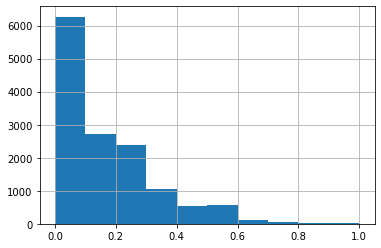

In [54]:
df_grouped['score_prop_famous_actors'].hist()

# 3.7 Merge score with actors

In [55]:
list_columns = ['score_'+x for x in list_function_score] + ['F_'+x for x in list_function_score] + ['M_'+x for x in list_function_score]

In [56]:
df_chars_merged = df_chars_numbers.merge(df_grouped[list_columns], left_on='wikipedia_m_ID', right_index=True, how='left').copy()
df_chars_merged.head(3)

,wikipedia_m_ID,m_release_date,character_name,actor_dob,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age,m_genre_PCA,...,F_mean,F_median,F_nb_famous_actors,F_prop_famous_actors,M_max,M_min,M_mean,M_median,M_nb_famous_actors,M_prop_famous_actors
0,975900,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,"Thriller, Crime Thriller, Action, Mystery",...,147.516667,53.55,3.0,0.6,1458.8,0.0,213.828571,0.0,2.0,0.4
1,975900,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,NaN,Natasha Henstridge,27.0,"Thriller, Crime Thriller, Action, Mystery",...,147.516667,53.55,3.0,0.6,1458.8,0.0,213.828571,0.0,2.0,0.4
2,975900,2001-08-24,Desolation Williams,1969-06-15,M,1.727,African Americans,Ice Cube,32.0,"Thriller, Crime Thriller, Action, Mystery",...,147.516667,53.55,3.0,0.6,1458.8,0.0,213.828571,0.0,2.0,0.4


# 3.8 Number of actors revealed per movie

In [57]:
df_chars_merged['is_revealed'] = df_chars_merged.apply(lambda row: row['min_year'] == row['m_release_date'].year, axis=1).astype(int)
df_chars_merged['already_revealed'] = df_chars_merged.apply(lambda row: row['min_year'] < row['m_release_date'].year and row['min_year']!=0.0, axis=1).astype(int)
df_chars_merged.head()

,wikipedia_m_ID,m_release_date,character_name,actor_dob,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age,m_genre_PCA,...,F_nb_famous_actors,F_prop_famous_actors,M_max,M_min,M_mean,M_median,M_nb_famous_actors,M_prop_famous_actors,is_revealed,already_revealed
0,975900,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,"Thriller, Crime Thriller, Action, Mystery",...,3.0,0.6,1458.8,0.0,213.828571,0.0,2.0,0.4,0,0
1,975900,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,NaN,Natasha Henstridge,27.0,"Thriller, Crime Thriller, Action, Mystery",...,3.0,0.6,1458.8,0.0,213.828571,0.0,2.0,0.4,0,1
2,975900,2001-08-24,Desolation Williams,1969-06-15,M,1.727,African Americans,Ice Cube,32.0,"Thriller, Crime Thriller, Action, Mystery",...,3.0,0.6,1458.8,0.0,213.828571,0.0,2.0,0.4,0,1
3,975900,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,"Thriller, Crime Thriller, Action, Mystery",...,3.0,0.6,1458.8,0.0,213.828571,0.0,2.0,0.4,0,1
4,975900,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea Duvall,23.0,"Thriller, Crime Thriller, Action, Mystery",...,3.0,0.6,1458.8,0.0,213.828571,0.0,2.0,0.4,0,0


# 4.1 Movies that have a revelation

In [58]:
df_movie_revelation = df_chars_merged.groupby('wikipedia_m_ID')['is_revealed'].sum().copy().reset_index()
df_movie_revelation.rename({'is_revealed' : 'has_revelation'}, axis=1, inplace=True)
df_movie_revelation['has_revelation'] = (df_movie_revelation['has_revelation'] > 0).astype(int)
df_movie_revelation.head()

,wikipedia_m_ID,has_revelation
0,3217,1
1,3746,1
2,3947,0
3,4231,0
4,4560,0


In [59]:
df_movie_revelation['has_revelation'].value_counts()

0    11934
1     1778
Name: has_revelation, dtype: int64

In [60]:
df_chars_revelation = df_chars_merged.merge(df_movie_revelation, on='wikipedia_m_ID', how='left').copy().sort_values(['wikipedia_m_ID', 'is_revealed'], ascending=False)

In [61]:
df_revelation = df_chars_revelation.drop_duplicates(subset=['wikipedia_m_ID', 'has_revelation'], keep='first')

In [62]:
df_revelation = df_revelation[df_revelation['score_nb_famous_actors'] > 0].copy()

In [63]:
df_revelation.groupby('has_revelation').mean()

,wikipedia_m_ID,actor_height,actor_age,nb_actors,1980,1981,1982,1983,1984,1985,...,F_nb_famous_actors,F_prop_famous_actors,M_max,M_min,M_mean,M_median,M_nb_famous_actors,M_prop_famous_actors,is_revealed,already_revealed
has_revelation,,,,,,,,,,,,,,,,,,,,,
0,1.086704e+07,1.857208,39.909626,9.743439,49.022984,65.120394,85.090174,123.363918,129.002000,181.842168,...,0.803172,0.346777,1174.134298,8.141344,216.927049,37.477493,1.521591,0.674845,0.0,0.337953
1,8.159055e+06,1.751611,32.707248,13.148789,0.000000,8.751557,13.848443,17.038293,24.187313,38.702791,...,0.955727,0.325913,1839.037424,0.328166,269.773880,18.969851,1.986851,0.678703,1.0,0.000000


<AxesSubplot:xlabel='has_revelation', ylabel='score_prop_famous_actors'>

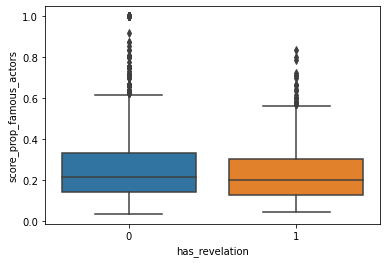

In [64]:
sns.boxplot(data=df_revelation, x='has_revelation',y='score_prop_famous_actors')

In [65]:
df_revelation.groupby('has_revelation')['M_prop_famous_actors'].mean()

has_revelation
0    0.674845
1    0.678703
Name: M_prop_famous_actors, dtype: float64

In [66]:
df_revelation.groupby('has_revelation')['F_prop_famous_actors'].mean()

has_revelation
0    0.346777
1    0.325913
Name: F_prop_famous_actors, dtype: float64

<AxesSubplot:xlabel='has_revelation', ylabel='M_prop_famous_actors'>

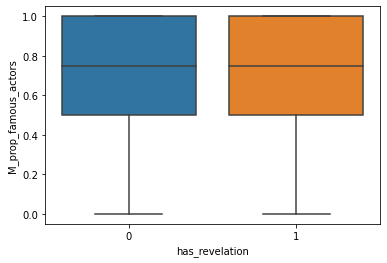

In [67]:
sns.boxplot(data=df_revelation, x='has_revelation',y='M_prop_famous_actors')

<AxesSubplot:xlabel='has_revelation', ylabel='F_prop_famous_actors'>

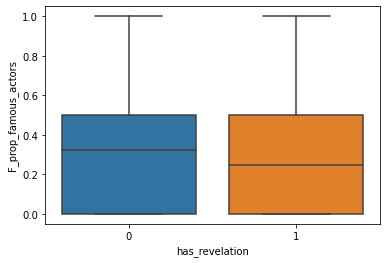

In [68]:
sns.boxplot(data=df_revelation, x='has_revelation',y='F_prop_famous_actors')

In [69]:
list_columns

['score_max',
 'score_min',
 'score_mean',
 'score_median',
 'score_nb_famous_actors',
 'score_prop_famous_actors',
 'F_max',
 'F_min',
 'F_mean',
 'F_median',
 'F_nb_famous_actors',
 'F_prop_famous_actors',
 'M_max',
 'M_min',
 'M_mean',
 'M_median',
 'M_nb_famous_actors',
 'M_prop_famous_actors']

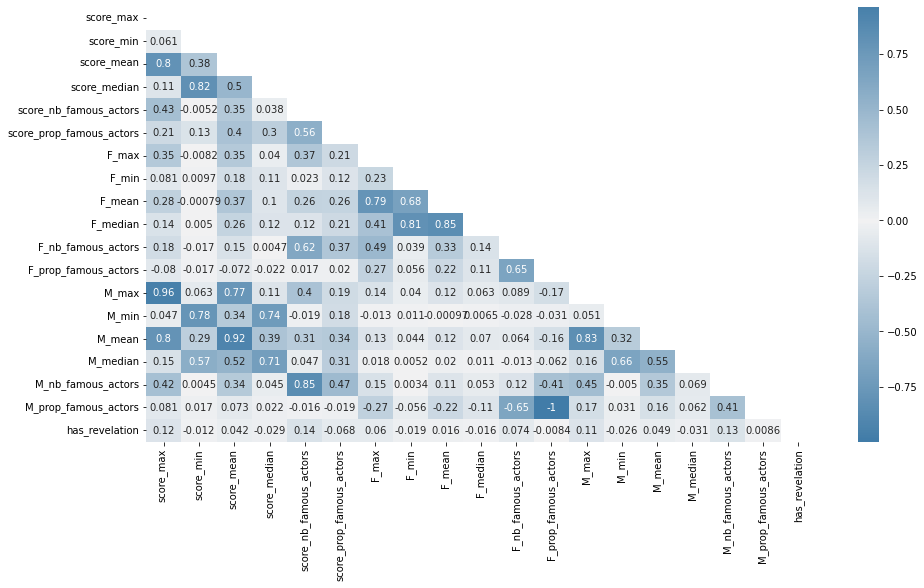

In [70]:
columns = list_columns+['wikipedia_m_ID', 'actor_name', 'has_revelation']
dataset = df_revelation[columns].groupby(['wikipedia_m_ID', 'actor_name']).mean().fillna(0)

# Heatmap of the correlation between the attributes
corr = dataset.corr()
mask = np.triu(np.ones_like(corr, dtype='bool'))

plt.figure(figsize=(15, 8))
cmap = sns.diverging_palette(240,240, as_cmap=True)
sns.heatmap(data=corr, cmap=cmap, center=0, mask=mask, annot=True)
plt.show()

In [71]:
X = dataset.drop('has_revelation', axis=1)
y = dataset['has_revelation']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Dictionary to store the results
logistic_regression_results = dict()

# Build and fit classifier to training data
clf = LogisticRegression(max_iter=10000, C=0.5, class_weight='balanced')
clf.fit(X_train, y_train)

# Training set accuracy
y_pred = clf.predict(X_train)
acc_tr = accuracy_score(y_pred, y_train) * 100
print("Accuracy on the training data: {:.2f}%".format(acc_tr))

Accuracy on the training data: 63.55%


In [72]:
# Predict the binary output with a cross validationn
y_pred = cross_val_predict(clf, X_test, y_test, cv=10, method="predict")
# Compute the False Positive Rate and True Positive Rate
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

         0.0       0.61      0.89      0.72      1396
         1.0       0.64      0.26      0.37      1073

    accuracy                           0.61      2469
   macro avg       0.62      0.57      0.55      2469
weighted avg       0.62      0.61      0.57      2469



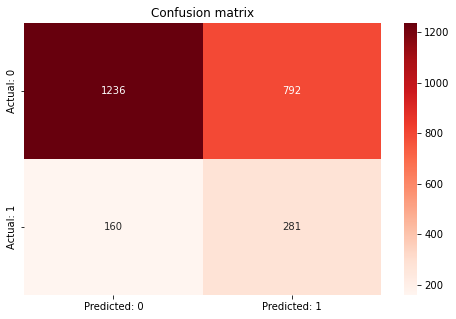

In [73]:
# Creation of confusion matrix
cm = confusion_matrix(y_test, y_pred)
conf_matrix=pd.DataFrame(data=cm, columns=['Predicted: 0', 'Predicted: 1'], index=['Actual: 0', 'Actual: 1'])
logistic_regression_results.update({'cm': conf_matrix})

# Plot confusion matrix
plt.figure(figsize=(8, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap = 'Reds')
plt.title("Confusion matrix")
plt.show()

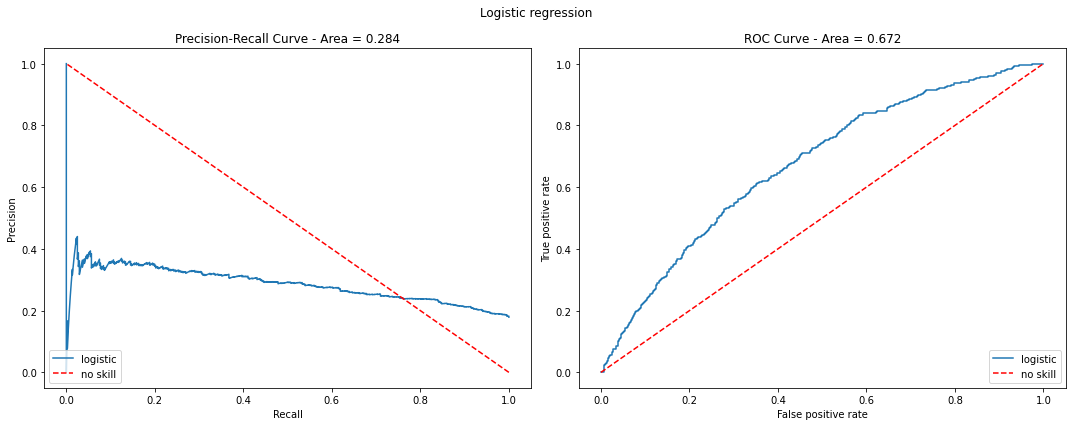

In [74]:
# Predict the probabilities with a cross validationn
y_pred = cross_val_predict(clf, X_test, y_test, cv=10, method="predict_proba")

#Compute the precision and recall
precision, recall, _ = precision_recall_curve(y_test, y_pred[:, 1])

#Compute the false positive rate and true positive rate
fpr, tpr, _ = roc_curve(y_test, y_pred[:, 1])

# Compute the area under the P-R curve and ROC curve
pr_score = auc(recall, precision)
roc_score = auc(fpr, tpr)

# Plot P-R curve and ROC curve
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

ax = axs[0]
ax.plot(recall, precision, label='logistic')
ax.plot([1, 0], [0, 1],'r--', label = 'no skill')
ax.set_xlabel("Recall")
ax.set_ylabel("Precision")
ax.set_title("Precision-Recall Curve - Area = {:.3f}".format(pr_score))
ax.legend(loc = 'lower left')

ax = axs[1]
ax.plot(fpr, tpr, label='logistic')
ax.plot([0, 1], [0, 1],'r--', label = 'no skill')
ax.set_xlabel("False positive rate")
ax.set_ylabel("True positive rate")
ax.set_title("ROC Curve - Area = {:.3f}".format(roc_score))
ax.legend(loc = 'lower right')

fig.suptitle('Logistic regression')
fig.tight_layout()
plt.show()

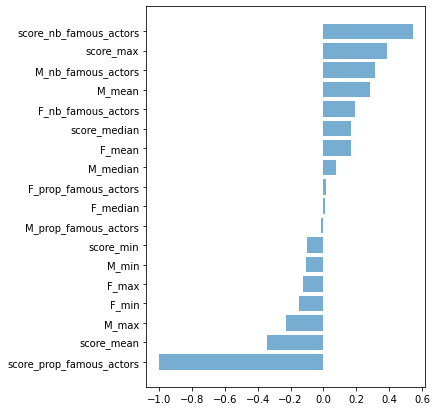

In [75]:
# Weight of each column in logistic regression
tmp = []
for name, value in zip(dataset.columns, clf.coef_[0]):
    tmp.append({"name": name, "value": value})
    
features_coef = pd.DataFrame(tmp).sort_values("value")

plt.subplots(figsize=(5,7))
plt.barh(features_coef.name, features_coef.value, alpha=0.6)
plt.show()

# 5.1 Carreer booster

In [76]:
df_movie_revelation = df_chars_revelation[df_chars_revelation['has_revelation'] > 0].copy()
df_movie_revelation.head()

,wikipedia_m_ID,m_release_date,character_name,actor_dob,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age,m_genre_PCA,...,F_prop_famous_actors,M_max,M_min,M_mean,M_median,M_nb_famous_actors,M_prop_famous_actors,is_revealed,already_revealed,has_revelation
6511,36229546,2012-01-20,Jesse,1978-08-18,M,1.77,Jewish people,Andy Samberg,33.0,"Gay, Gay Interest, Gay Themed, LGBT",...,0.25,516.526316,0.0,60.263238,0.0,3.0,0.75,1,0,1
6506,36229546,2012-01-20,NaN,1971-11-09,M,NaN,NaN,Jason Antoon,40.0,"Gay, Gay Interest, Gay Themed, LGBT",...,0.25,516.526316,0.0,60.263238,0.0,3.0,0.75,0,0,1
6507,36229546,2012-01-20,Scott,1981-01-28,M,1.68,English American,Elijah Wood,30.0,"Gay, Gay Interest, Gay Themed, LGBT",...,0.25,516.526316,0.0,60.263238,0.0,3.0,0.75,0,1,1
6508,36229546,2012-01-20,Riley,1991-02-10,F,1.60,NaN,Emma Roberts,20.0,"Gay, Gay Interest, Gay Themed, LGBT",...,0.25,516.526316,0.0,60.263238,0.0,3.0,0.75,0,1,1
6509,36229546,2012-01-20,Celeste,1976-02-25,F,1.63,African Americans,Rashida Jones,35.0,"Gay, Gay Interest, Gay Themed, LGBT",...,0.25,516.526316,0.0,60.263238,0.0,3.0,0.75,0,0,1


In [77]:
df_chars_already_revealed = df_movie_revelation[df_movie_revelation['already_revealed'] == 1].copy()
df_chars_already_revealed.head()

,wikipedia_m_ID,m_release_date,character_name,actor_dob,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age,m_genre_PCA,...,F_prop_famous_actors,M_max,M_min,M_mean,M_median,M_nb_famous_actors,M_prop_famous_actors,is_revealed,already_revealed,has_revelation
6507,36229546,2012-01-20,Scott,1981-01-28,M,1.68,English American,Elijah Wood,30.0,"Gay, Gay Interest, Gay Themed, LGBT",...,0.25,516.526316,0.0,60.263238,0.00,3.0,0.75,0,1,1
6508,36229546,2012-01-20,Riley,1991-02-10,F,1.60,NaN,Emma Roberts,20.0,"Gay, Gay Interest, Gay Themed, LGBT",...,0.25,516.526316,0.0,60.263238,0.00,3.0,0.75,0,1,1
6512,36229546,2012-01-20,Tucker,1977-05-31,M,1.88,white Americans,Eric Christian Olsen,34.0,"Gay, Gay Interest, Gay Themed, LGBT",...,0.25,516.526316,0.0,60.263238,0.00,3.0,0.75,0,1,1
6513,36229546,2012-01-20,Paul,1974-08-11,M,1.75,NaN,Chris Messina,37.0,"Gay, Gay Interest, Gay Themed, LGBT",...,0.25,516.526316,0.0,60.263238,0.00,3.0,0.75,0,1,1
99054,35589999,2012-09-01,Susanna,1960-12-03,F,1.60,Scottish American,Julianne Moore,NaN,"Mystery, Horror, Children's/Family, Drama",...,0.50,408.500000,0.0,204.250000,204.25,1.0,0.50,0,1,1


In [78]:
df_tmp = df_chars_already_revealed.groupby('actor_name')['already_revealed'].sum().reset_index().sort_values('already_revealed', ascending=False).copy()
df_tmp.rename({'already_revealed':'nb_movies_when_revelation'}, axis=1, inplace=True)

In [79]:
df_nb_movies_carreer_booster = df_chars_revelation[df_chars_revelation['already_revealed'] == 1].groupby('actor_name')['wikipedia_m_ID'].count().reset_index().sort_values('wikipedia_m_ID', ascending=False).copy()
df_nb_movies_carreer_booster.rename({'wikipedia_m_ID': 'nb_movies'}, axis=1, inplace=True)

In [80]:
df_carreer_booster = df_nb_movies_carreer_booster.merge(df_tmp, on='actor_name', how='left').copy()
df_carreer_booster['nb_movies_when_revelation'] = df_carreer_booster['nb_movies_when_revelation'].fillna(0)
df_carreer_booster['ratio_movies_when_revelation'] = df_carreer_booster.apply(lambda row: row['nb_movies_when_revelation']*row['nb_movies_when_revelation'] / row['nb_movies'], axis=1)

In [81]:
df_carreer_booster.sort_values(['nb_movies_when_revelation', 'ratio_movies_when_revelation'], ascending=False).head(22)

,actor_name,nb_movies,nb_movies_when_revelation,ratio_movies_when_revelation
2,Bruce Willis,71,24.0,8.112676
20,Ben Stiller,51,21.0,8.647059
6,Robert De Niro,63,20.0,6.349206
4,John Goodman,64,20.0,6.250000
30,Matt Damon,48,18.0,6.750000
21,Dennis Quaid,51,18.0,6.352941
15,Dan Aykroyd,54,18.0,6.000000
1,Samuel L. Jackson,73,18.0,4.438356
54,Bill Murray,42,17.0,6.880952
48,Tom Hanks,44,17.0,6.568182


# 6.1 Stay in the loop

In [82]:
df_numbers_yearly.head(2)

,actor_name,1980,1981,1982,1983,1984,1985,1986,1987,1988,...,2005,2006,2007,2008,2009,2010,2011,2012,min_year,min_year_score
0,Jane Fonda,2475.0,3910.5,2161.5,1509.75,1163.25,947.100000,2689.071429,1636.232143,1239.125000,...,3026.612308,1649.474359,1183.301948,945.483026,799.422414,699.538710,626.261864,569.781250,1980,2475.0
1,Clint Eastwood,5394.0,2697.0,4636.0,5963.50,9801.80,8879.333333,8991.838095,5988.366667,7511.228571,...,5771.129002,4778.685758,4185.983006,8665.604883,5901.331475,4831.223973,4212.135890,4683.724922,1980,5394.0


In [83]:
columns = df_numbers_yearly.columns[1:]

In [84]:
df_loop = df_chars_merged.loc[(df_chars_merged['already_revealed']==1) & (df_chars_merged['nb_years_acting']>=1)].sort_values(['actor_name', 'm_release_date']).drop_duplicates(['actor_name'], keep='first').copy()
df_loop.drop(columns, axis=1, inplace=True)
df_loop = df_loop.merge(df_numbers_yearly, on='actor_name', how='left').copy()
df_loop.dropna(subset=['actor_gender'], inplace=True)
df_loop.head()

KeyError: 'nb_years_acting'

In [85]:
df_loop['actor_gender'].value_counts()

NameError: name 'df_loop' is not defined

In [ ]:
def get_score_year(row):
    release_year = row['m_release_date'].year
    return int(row['{}'.format(release_year)] > 0)

In [ ]:
df_loop['still_ranked'] = df_loop.apply(lambda row: get_score_year(row), axis=1)

In [ ]:
df_loop['is_main_actor'] = (df_loop['score_max'] == df_loop['min_year_score']).astype(int)

In [ ]:
df_loop['is_main_actor'].sum()

In [ ]:
df_loop['still_ranked'].sum()

In [ ]:
df_loop[df_loop['still_ranked'] == 1]['is_main_actor'].sum()

In [ ]:
df_loop.loc[(df_loop['is_main_actor'] == 0) & (df_loop['still_ranked'] == 0)].shape

In [ ]:
df_loop.loc[(df_loop['is_main_actor'] == 1) & (df_loop['still_ranked'] == 0)].shape

In [ ]:
df_loop.loc[(df_loop['is_main_actor'] == 1) & (df_loop['still_ranked'] == 1)].shape

In [ ]:
df_loop.loc[(df_loop['is_main_actor'] == 0) & (df_loop['still_ranked'] == 1)].shape

In [ ]:
#df_loop.drop_duplicates('wikipedia_m_ID', keep='first', inplace=True)

In [ ]:
df_loop['wikipedia_m_ID'].nunique()

In [ ]:
df_loop.groupby('still_ranked')[list_columns+['is_main_actor']].mean()

In [ ]:
df_loop[df_loop['actor_gender']=='M'].groupby('still_ranked')[list_columns+['is_main_actor']].mean()

In [ ]:
df_loop[df_loop['actor_gender']=='F'].groupby('still_ranked')[list_columns+['is_main_actor']].mean()

In [ ]:
sns.histplot(data=df_loop,x='actor_gender',hue='still_ranked', cumulative=False, multiple='fill', stat='proportion')
plt.grid();

In [ ]:
sns.boxplot(data=df_loop,x='actor_gender',y='score_max', hue='still_ranked')

In [ ]:
sns.boxplot(data=df_loop,x='actor_gender',y='F_max', hue='still_ranked')

In [ ]:
sns.boxplot(data=df_loop,x='actor_gender',y='M_max', hue='still_ranked')

In [ ]:
df_tmp = df_loop.dropna()
ttest_ind(df_tmp[df_tmp['still_ranked']==1]['M_max'], df_tmp[df_tmp['still_ranked']==0]['M_max'])

In [ ]:
ttest_ind(df_tmp[df_tmp['still_ranked']==1]['F_max'], df_tmp[df_tmp['still_ranked']==0]['F_max'])

# 6.2 Correlation

In [ ]:
columns = list_columns+['wikipedia_m_ID', 'actor_name', 'still_ranked']
dataset = df_loop[columns].groupby(['wikipedia_m_ID', 'actor_name']).mean().fillna(0)

# Heatmap of the correlation between the attributes
corr = dataset.corr()
mask = np.triu(np.ones_like(corr, dtype='bool'))

plt.figure(figsize=(15, 8))
cmap = sns.diverging_palette(240,240, as_cmap=True)
sns.heatmap(data=corr, cmap=cmap, center=0, mask=mask, annot=True)
plt.show()

In [ ]:
X = dataset.drop('still_ranked', axis=1)
y = dataset['still_ranked']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Dictionary to store the results
logistic_regression_results = dict()

# Build and fit classifier to training data
clf = LogisticRegression(solver='lbfgs', max_iter=10000,penalty='l2', C=0.2, class_weight='balanced')
clf.fit(X_train, y_train)

# Training set accuracy
y_pred = clf.predict(X_train)
acc_tr = accuracy_score(y_pred, y_train) * 100
print("Accuracy on the training data: {:.2f}%".format(acc_tr))

In [ ]:
# Predict the binary output with a cross validationn
y_pred = cross_val_predict(clf, X_test, y_test, cv=10, method="predict")
# Compute the False Positive Rate and True Positive Rate
print(classification_report(y_pred, y_test))

In [ ]:
# Creation of confusion matrix
cm = confusion_matrix(y_test, y_pred)
conf_matrix=pd.DataFrame(data=cm, columns=['Predicted: 0', 'Predicted: 1'], index=['Actual: 0', 'Actual: 1'])
logistic_regression_results.update({'cm': conf_matrix})

# Plot confusion matrix
plt.figure(figsize=(8, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap = 'Reds')
plt.title("Confusion matrix")
plt.show()

In [ ]:
# Predict the probabilities with a cross validationn
y_pred = cross_val_predict(clf, X_test, y_test, cv=10, method="predict_proba")

#Compute the precision and recall
precision, recall, _ = precision_recall_curve(y_test, y_pred[:, 1])

#Compute the false positive rate and true positive rate
fpr, tpr, _ = roc_curve(y_test, y_pred[:, 1])

# Compute the area under the P-R curve and ROC curve
pr_score = auc(recall, precision)
roc_score = auc(fpr, tpr)

# Plot P-R curve and ROC curve
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

ax = axs[0]
ax.plot(recall, precision, label='logistic')
ax.plot([1, 0], [0, 1],'r--', label = 'no skill')
ax.set_xlabel("Recall")
ax.set_ylabel("Precision")
ax.set_title("Precision-Recall Curve - Area = {:.3f}".format(pr_score))
ax.legend(loc = 'lower left')

ax = axs[1]
ax.plot(fpr, tpr, label='logistic')
ax.plot([0, 1], [0, 1],'r--', label = 'no skill')
ax.set_xlabel("False positive rate")
ax.set_ylabel("True positive rate")
ax.set_title("ROC Curve - Area = {:.3f}".format(roc_score))
ax.legend(loc = 'lower right')

fig.suptitle('Logistic regression')
fig.tight_layout()
plt.show()

In [ ]:
# Weight of each column in logistic regression
tmp = []
for name, value in zip(dataset.columns, clf.coef_[0]):
    tmp.append({"name": name, "value": value})
    
features_coef = pd.DataFrame(tmp).sort_values("value")

plt.subplots(figsize=(5,7))
plt.barh(features_coef.name, features_coef.value, alpha=0.6)
plt.show()

# 7 Analysis by decade

In [ ]:
df_revelation['m_release_dec'] = df_revelation['m_release_date'].apply(lambda x: x.year//10*10)

In [ ]:
df_revelation.groupby(['m_release_dec', 'has_revelation']).mean()

In [ ]:
plt.figure(figsize=(15, 6))
sns.boxplot(data=df_revelation, x='m_release_dec', y='nb_actors')

In [ ]:
plt.figure(figsize=(15, 6))
sns.boxplot(data=df_revelation, x='m_release_dec', y='score_prop_famous_actors', hue='has_revelation')

In [ ]:
df_revelation[df_revelation['m_release_dec'] >= 2010]

In [ ]:
plt.figure(figsize=(15, 6))
sns.histplot(data=df_revelation, x='m_release_dec');

In [ ]:
plt.figure(figsize=(15, 6))
sns.boxplot(data=df_revelation, x='m_release_dec', y='score_mean', hue='has_revelation')

In [ ]:
df_revelation.columns

In [ ]:
for dec in df_revelation['m_release_dec'].sort_values().unique():
    df_tmp = df_revelation[df_revelation['m_release_dec'] == dec]
    

In [ ]:
df_revelation[df_revelation['nb_movies_dec_1990_2000'] >0]

In [ ]:
df_revelation.loc[(df_revelation['m_release_date'].dt.year >= 2010) & (df_revelation['m_release_date'].dt.year < 2020)].groupby('has_revelation').mean()

In [ ]:
df_revelation.loc[(df_revelation['m_release_date'].dt.year >= 2000) & (df_revelation['m_release_date'].dt.year < 2010)].groupby('has_revelation').mean()

In [ ]:
df_revelation.loc[(df_revelation['m_release_date'].dt.year >= 1990) & (df_revelation['m_release_date'].dt.year < 2000)].groupby('has_revelation').mean()

In [ ]:
df_revelation.loc[(df_revelation['m_release_date'].dt.year < 1990)].groupby('has_revelation').mean()